## softmax回归——分类过程（注意！）

- 标签：使用**one-hot encoding**
- softmax回归是一种单层神经网络，并且输出层是全连接层
- 向量形式表达为$\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}$
- softmax函数能够将未规范化的预测变换为非负数并且总和为1，同时让模型保持
可导的性质  
softmax运算不会改变未规范化的预测$\mathbf{o}$之间的大小次序，只会确定分配给每个类别的概率
- 小批量样本的矢量化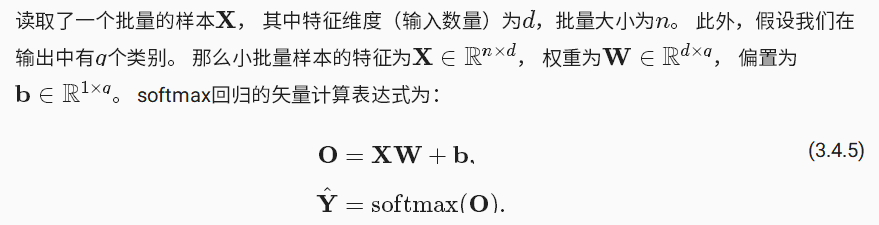  
加快了矩阵-向量乘法
- 一种：通过**最小化负对数似然函数**，得到对应的损失函数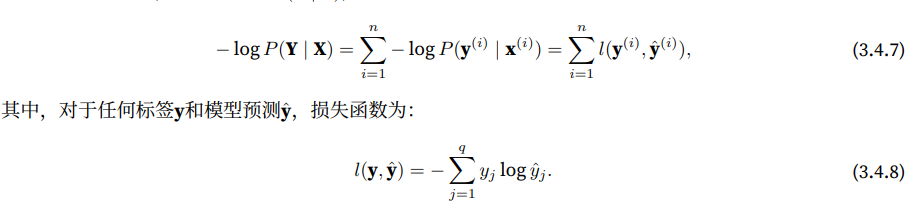
- 损失函数的导数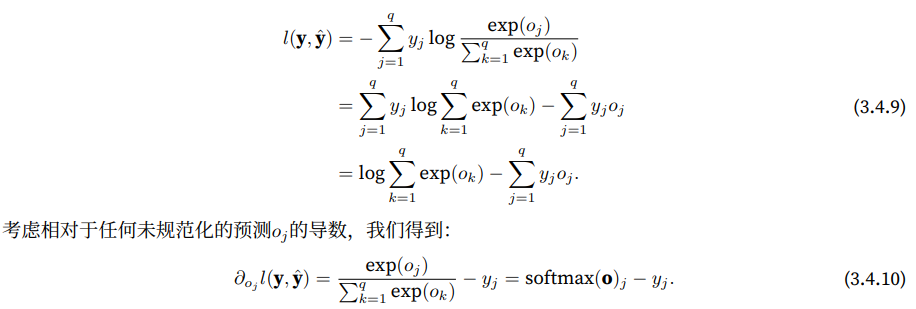
- 一种：**最小化传达标签所需的惊异**（从熵的角度看问题）
- 在接下来的实验中，我们将使用**精度**（accuracy）来评估模型的性能  
精度等于正确预测数与预测总数之间的比率



### 小结
- softmax运算获取一个向量并将其映射为**概率**
- softmax回归适用于分类问题，它使用了softmax运算中输出类别的**概率分布**
- 交叉熵是一个衡量两个概率分布之间**差异**的很好的度量，它测量给定模型编码数据所需的比特数

### 课
- Softmax回归是一个多分类模型
- 使用Softmax操作得到每个类的预测置信度（概率）
- 使用交叉熵来衡量预测和标号的区别
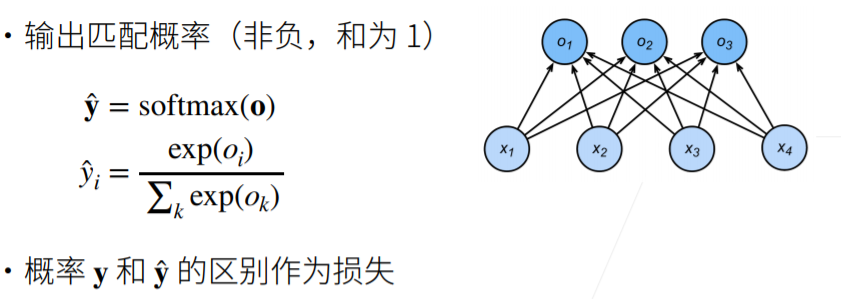
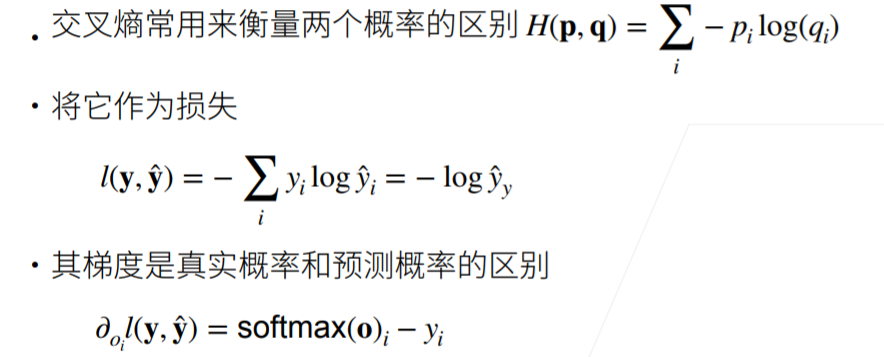
- 当$\hat{y}_i$接近$y_i$时，梯度趋近于0，意味着权重的更新步伐会减慢；  
当$\hat{y}_i$和$y_i$差距较大时，梯度也较大，表示模型预测有偏差，需较大步幅进行更新
- 补充一个似然函数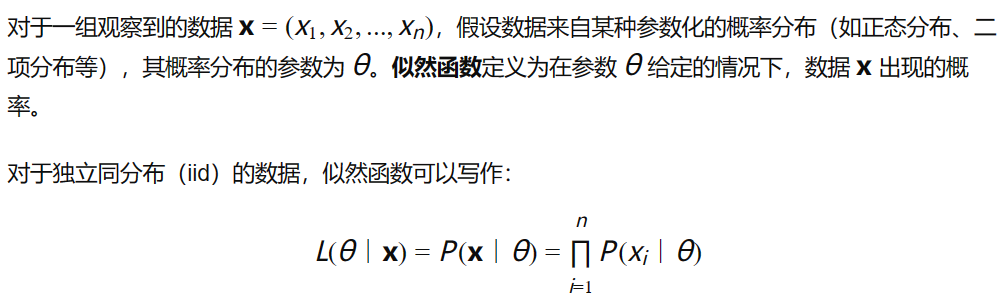

### 损失函数
1. L2loss——离真实值远的时候，梯度大，参数更新的幅度大，但有有时候不一定想那么大的参数来更新参数
- **最小化 L2 损失等价于最大化假设误差服从正态分布的似然函数**
2. L1loss——不管离真实值多远，梯度都是常数；但有不平滑性
3. Huber's Robust Loss——离真实值远，梯度常数（均匀下降）；离的近，梯度绝对值越来越小，保证优化比较平滑
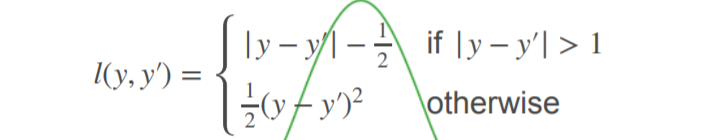

## 图像分类数据集

In [1]:
%matplotlib inline
import torch
import torchvision

from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display() # 使用 SVG 格式来显示更清晰的图像

### 读取数据集
- `transforms.ToTensor()`：  
对数据进行预处理——将图像数据从`PIL`或`NumPy`转为`Tensor`  
将图像数据从整数自动缩放到32位浮点数，并数值归一化到[0, 1]
- `torchvision.datasets.FashionMNIST`
- 数据以**tensor形式**储存，可以通过`DataLoader`来进行批量加载并传递给模型进行训练和测试


In [2]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root='./data',   # 数据集的储存位置
    train=True,      # 加载训练集（False：测试集）
    transform=trans, # 应用ToTensor转换，将图像转换为Tensor类型
    download=True    # 如果数据集不存在，下载数据集
)
mnist_test = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=trans, download=True)

100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.6%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



119.3%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw




C:\Users\lenovo\.conda\envs\fxr_env2\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
print(type(mnist_train), mnist_train[0][0].shape, len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'> torch.Size([1, 28, 28]) 60000 10000


以下函数用于在数字标签索引及其文本名称之间进行**转换**

In [4]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

创建一个函数来**可视化**这些样本，绘制出图像*列表*  
- 能将一组图像以网格方式显示出来，并且支持显示**PyTorch张量**格式的图像以及**PIL图像**
- axes.flatten()：将轴平铺，使得`axes`对象从二维数组变成一维数组，不用通过二维索引
- 图像是*张量*——`torch.is_tensor(img)`，要转`.numpy()`
- `ax`是子图，`ax.axes`返回的是`ax`所属的坐标系

In [5]:
def show_image(imgs, num_rows, num_cols, scale=1.5, titles=None):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
#   return axes  # 返回所有子图对象axes

训练集中**前几个**图像及其对应的标签
- `X.shape`：`torch.Size([18, 1, 28, 28])`
- `DataLoader`, `iter`, `next`

In [ ]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_image(X.reshape(-1, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

### 读取小批量
- 为了使读取训练集和测试集时更容易，使用内置的**数据迭代器**
- 通过内置数据迭代器，可以随机**打乱**所有样本，从而无偏见地读取小批量
- `get_dataloader_workers`：决定了又多少个CPU进程同时用于读取和预处理数据，从而提高数据加载的效率


In [23]:
batch_size = 256

def get_dataloader_workers():
    """
    使用4个进程来读取数据
    """
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, 
                             shuffle=True, num_workers=get_dataloader_workers()
                            )

读取训练数据所需的**时间**  
- （有的模型训练很快但是读取数据很慢，**通常在训练前看一下数据读取的速度**，读的至少要比训练快）
- `d2l.Timer()`记录程序运行时间
- 启动计时：`Timer()`
- 停止计时：`timer.stop()`，并返回从开始到停止的时间差
- `continue`表示不执行任何操作，仅遍历所有批次

In [24]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'18.49 sec'

### 整合所有组件
- 流程——*图像预处理* - *数据集下载和加载* - *返回数据加载器*
- 定义`load_data_fashion_mnist`函数：+可以调整图像的大小为另一种形状
- `trans.insert(index, object)`：将指定的对象插入到列表的某个位置
- `transforms.Resize()`；调整大小
- `transforms.Compose()`：将一系列图像变换操作组合在一起，使其可以顺序执行

In [26]:
def load_data_fashion_mnist(batch_size, resize=None):
    """
    下载Fashion-MNSIT数据集，然后将其加载到内存中
    """
    trans = [transforms.ToTensor()]  # 列表
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root='.\data', train=True, transform=trans, download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root='.\data', train=False, transform=trans, download=True
    )
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [27]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


### 小结

* Fashion-MNIST是一个服装分类数据集，由10个类别的图像组成。我们将在后续章节中使用此数据集来评估各种分类算法。
* 我们将高度$h$像素，宽度$w$像素图像的形状记为$h \times w$或（$h$,$w$）。
* 数据迭代器是获得更高性能的关键组件。依靠实现良好的数据迭代器，利用高性能计算来避免减慢训练过程。

### 练习

1. 减少`batch_size`（如减少到1）是否会影响读取性能？
1. 数据迭代器的性能非常重要。当前的实现足够快吗？探索各种选择来改进它。
1. 查阅框架的在线API文档。还有哪些其他数据集可用？


### 回答
1. 减少`batch_size`会显著影响数据加载和训练的性能  
小`batch_size`会增加数据加载器的调用频率——可能会增加I/O操作的开销，并导致训练过程中CPU或GPU等待数据  
小`batch_size`会使得硬件资源利用率降低；大`batch_size`可以更好的利用并行计算能力，从而提升计算效率
2. 目前的实现（基于PyTorch的`DataLoader`）已经非常高效，特别是当`num_workers`设置为多进程时  
调整`num_workers`  
预处理优化  
缓存数据，数据集不大可以将整个数据集加载到内存中，避免频繁的磁盘I/O操作
3. 在PyTorch的`torchvision.datasets`模块中，有多个常用的数据集，可以直接使用

## softmax回归的从0实现
使用`Fashion-MNIST`数据集，并设置数据迭代器的批量大小是256

In [28]:
import torch

from IPython import display
from d2l import torch as d2l

batch_size=256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



### 初始化模型参数
- 需要将每个样本用固定长度的**向量**来表示，28*28=784长度的向量——将每个像素位置看成一个**特征**
- 构建一个$784\times 10$的**矩阵**，偏置项则是一个$1\times 10$的行向量

In [38]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

### 定义softmax操作

`sum`运算符沿张量中特定维度工作

In [33]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5, 7, 9]]),
 tensor([[ 6],
         [15]]))

**实现softmax**的三个步骤：
- 对每项求幂`exp`
- 对每行求和（小批量中个样本是一行），得到每个样本的规范化常数
- 每一行除以其规范化常数，确保结果的和为1

In [53]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    # print(X.shape, partition.shape)
    return X_exp / partition  # 使用广播机制

In [54]:
X = torch.normal(0, 1, (2, 5))
X_probability = softmax(X)
X_probability, X_probability.sum(1)

(tensor([[0.4282, 0.2006, 0.2147, 0.1462, 0.0103],
         [0.1288, 0.3959, 0.2067, 0.0893, 0.1793]]),
 tensor([1., 1.]))

### 定义模型
**softmax回归模型**
- 数据传递到模型之前，要先使用`reshape`函数将每张原始图像展平为向量

In [73]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 定义损失函数
- **交叉熵损失函数**
- 交叉熵采用真实标签的预测概率的负对数似然——不使用for循环迭代预测（低效）
- **通过运算符选择所有的元素**
- 下例：  
创建一个数据样本`y_hat`，包含2个样本在3个类别的预测概率，
及对应的标签`y`  
**使用`y`作为`y_hat`中概率的索引**

In [74]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

只需要**一行**代码就可以实现**交叉熵损失函数**

In [75]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [76]:
y.dtype

torch.int64

### 分类精度
- 直接优化精度可能很困难，但是精度通常是最关心的性能**衡量标准**，在训练分类器几乎总会关注
- 等式运算符`==`对**数据类型**很敏感，故要将数据类型转换为一致的
- `if`：判断`y_hat`是否是一个二维张量，并且每一个是否包含多个类别的概率
- `.dtype`：在PyTroch中是张量的一个属性，表示该张量的**数据类型**

- `cmp`是bool类型数据
- `accuracy`函数返回的是正确的个数

In [77]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:  
        y_hat = y_hat.argmax(axis=1) # 返回最大值所在索引
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [78]:
accuracy(y_hat, y) / len(y)

0.5

对于任意数据迭代器`data_iter`可访问的数据集，可以评估在**任意模型`net`的精度**
- `isinstance(object, classinfo)`：用于检查一个对象是否是指定类型（类或类型）的实例-返回`True`或`False`
- `torch.nn.Module`是PyTorch中所有神经网络模型的**基类**  
所有神经网络模型（包括自定义的模型），都需要**继承**自`torch.nn.Module`  
提供了一种**标准化**的方式来定义模型的层、参数和向前传播逻辑
- `if ininstance(net, torch.nn.Module)`通过这个检查，可以确保传入的`net`确实是一个**模型实例**，具备PyTorch模型的基本特性，如`eval()`、`train()`
- `Accumulator(n)`创建**累加器**，是一个自定义的辅助工具，用来累加n个变量

-  实现了**索引访问**的功能，通过`acc[idx]`来访问`data`列表中的元素

In [79]:
def evaluate_accuracy(net, data_iter):
    """
    计算在指定数据集上模型的精度，并返回平均准确率
    """
    if isinstance(net, torch.nn.Module):
        net.eval() # 不涉及梯度，评估模式就行
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

`Accumulator`类是一个用于在多个变量上累加的工具

In [80]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n  # 创建一个长度为n的列表data

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx] 

In [81]:
evaluate_accuracy(net, test_iter)

0.1284

### 训练

先定义一个函数来训练一个迭代周期
- `updater`是更新模型参数的常用函数，接受批量大小作为参数。可以是`d2l.sgd`函数，也可以是框架的内置优化函数

- `if isinstance(updater, torch.optim.Optimizer)`：看是否是**内置优化器**

In [82]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """
    训练模型一个迭代周期
    """
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3) # 训练损失总和、训练准确数量总和、样本数
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer): 
            updater.zero_grad()
            l.mean().backward()
            updater.step()      # 使用优化器更新模型的参数
        else:
            l.sum().backward()
            updater(X.shape[0]) # 调用自定义的优化器，传入当前批次的样本数
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

定义一个在**动画**中绘制数据的实用程序类  
具体**还未看**

In [83]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

### 训练函数
- 在每个迭代周期结束时，利用test_iter访问到的测试数据集对模型进行评估
- 利用Animator类来可视化训练进度
- 使用 assert 语句确保训练结果合理，防止训练失败或模型表现不佳

- **元组之间才能进行拼接**，不能直接将单个数值与元组拼接——`train_metrics`是元组，`(test_acc,)`是一个单元素的元组
- `assert`语句用于在代码执行时**验证某个条件是否为真**，如果不满足，程序会抛出一个`AssertionError`异常，并附带错误信息  
训练模型时用于快速检测和验证模型是否达到了预期的效果。如果某个条件不满足，则程序会立即停止，帮助我们快速定位训练中可能出现的问题。

In [84]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """
    训练模型
    """
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

**小批量随机梯度下降来优化模型的损失函数**，设置学习率为0.1

In [85]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([w, b], lr, batch_size)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

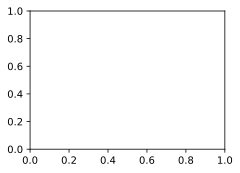

In [86]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [96]:
# 只显示6个
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X.argmax(axis=1))
    #titles = [true+'\n'+pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n#, titles=titles[0:n]
    )
    
predict_ch3(net, test_iter)

SyntaxError: invalid syntax (3130079387.py, line 8)

### 小结

* 借助softmax回归，我们可以训练多分类的模型。
* 训练softmax回归循环模型与训练线性回归模型非常相似：先读取数据，再定义模型和损失函数，然后使用优化算法训练模型。大多数常见的深度学习模型都有类似的训练过程。

### 练习

1. 本节直接实现了基于数学定义softmax运算的`softmax`函数。这可能会导致什么问题？提示：尝试计算$\exp(50)$的大小。
1. 本节中的函数`cross_entropy`是根据交叉熵损失函数的定义实现的。它可能有什么问题？提示：考虑对数的定义域。
1. 请想一个解决方案来解决上述两个问题。
1. 返回概率最大的分类标签总是最优解吗？例如，医疗诊断场景下可以这样做吗？
1. 假设我们使用softmax回归来预测下一个单词，可选取的单词数目过多可能会带来哪些问题?


### 回答
1. **数值稳定性问题**：指数函数的值可能会导致数值溢出，超出计算机的表示范围  
**解决方法**：可以减去输入向量中的最大值，这样不会改变`softmax`的输出结果，但是可以显著提高数值稳定性
2. 对数函数定义域是正数，若`softmax`的输出或标签为0，直接计算`log(0)`会导致数值问题（无穷大）  
**解决方法**：通常在概率值上加上一个非常小的数，如10^-8
4. 在医疗场景下，可能更关注**召回率**（识别所有阳性病例的能力），不仅仅是精度  
可以使用**基于阈值的分类**，而不是简单返回概率最大的标签
5. 直接选择softmax预测值最高的单词（贪心选择），可能会导致模型生成的文本**不够多样化**  
解决方法：采样方法、温度调节

## softmax回归的简洁实现
通过深度学习框架的**高级API**能够使实现softmax回归变得容易

In [97]:
import torch
from torch import nn
from d2l import torch as d2l

In [98]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 初始化模型

- softmax回归的**输出层**是一个**全连接层**
- 在`Sequential`中添加一个带有10个输出的全连接层
- PyTorch不会隐式的调整输入的形状——使用展平层（**第0维度保留**）
- `nn.Linear(784, 10)`：指输入是784，输出是10

- `if`：检查`m`是否为线性层
- `nn.init.normal_(m.weight, std=0.01)`：将线性层的权重初始化为服从正态分不到随机值  
`nn.init.normal_`是用于初始化张量的函数  
`m.weight`是正在初始化的线性层`m`的权重参数
- `net.apply(init_weight)`：遍历`net`中所有层，并对每一层应用`init_weight`函数

In [102]:
net = nn.Sequential(nn.Flatten(),        # 将输入展平
                    nn.Linear(784, 10))  # 线性层：将展平后的输入映射到10个输出神经元

def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weight)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

#### 在交叉熵损失函数中传递未归一化的预测，并同时计算softmax及其对数

In [103]:
loss = nn.CrossEntropyLoss()

#### 使用学习率为0.1的小批量随机梯度下降作为优化算法

In [104]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

### 训练
调用`train_ch3`函数来训练模型

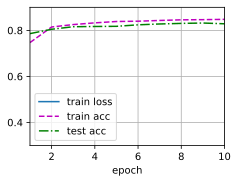

In [108]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 小结

* 使用深度学习框架的高级API，我们可以更简洁地实现softmax回归。
* 从计算的角度来看，实现softmax回归比较复杂。在许多情况下，深度学习框架在这些著名的技巧之外采取了额外的预防措施，来确保数值的稳定性。这使我们避免了在实践中从零开始编写模型时可能遇到的陷阱。

### 练习

1. 尝试调整超参数，例如批量大小、迭代周期数和学习率，并查看结果。
1. 增加迭代周期的数量。为什么测试精度会在一段时间后降低？我们怎么解决这个问题？


### 回答
2. 与**过拟合现象**有关  
训练时间过长会导致模型开始记住训练数据的**细节**（模型复杂度过高/缺乏正则化）  
过拟合**解决方法**：早停、正则化方法、减少模型复杂度、增加训练数据、数据增强

#### 注意：
soft label策略（软标签策略）：在训练深度学习模型时使用平滑的标签  
- 硬标签（hard），每个标签是一个独热编码
- 软标签，不是一个严格的0或1，而是一个概率分布


In [2]:
!nvidia-smi

Thu Oct 31 09:27:11 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.49       Driver Version: 457.49       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce MX150      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8    N/A /  N/A |     64MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA current device:", torch.cuda.current_device())
print("CUDA device name:", torch.cuda.get_device_name(0))  # 检查第一个 GPU 设备的名称


CUDA available: True
CUDA device count: 1
CUDA current device: 0
CUDA device name: GeForce MX150


In [4]:
# 创建一个在 GPU 上的张量
x = torch.randn(3, 3).cuda()
print("Tensor on GPU:", x)

# 在 GPU 上执行简单的矩阵运算
y = torch.mm(x, x)
print("Matrix multiplication result:", y)


Tensor on GPU: tensor([[-0.0745,  0.7555, -0.7006],
        [ 1.3812,  2.3681,  0.6875],
        [-0.6068,  0.8251,  1.2100]], device='cuda:0')
Matrix multiplication result: tensor([[ 1.4741,  1.1547, -0.2762],
        [ 2.7508,  7.2187,  1.4923],
        [ 0.4506,  2.4938,  2.4564]], device='cuda:0')


In [5]:
print("cuDNN available:", torch.backends.cudnn.is_available())


cuDNN available: True
